In [1]:
import numpy as np

In [4]:
beta1=2
beta2=1
beta3=4
num_cells=500

In [10]:
exp_lambda1=np.random.exponential(beta1,num_cells)
exp_lambda2=np.random.exponential(beta2,num_cells)
exp_lambda3=np.random.exponential(beta3,num_cells)

In [19]:
state=np.zeros(num_cells)
for i,e_lambda_2 in enumerate(exp_lambda2):
    if e_lambda_2 < exp_lambda3[i]:
        state[i]=2
    else:
        state[i]=3

In [24]:
timing_cell=[]
for cell in range(500):
    if state[cell]==2:
        final_time=exp_lambda2[cell]
    else:
        final_time=exp_lambda3[cell]
    cell_time=[(0,0),(1,exp_lambda1[cell]),(int(state[cell]),exp_lambda1[cell]+final_time)]
    timing_cell.append(cell_time)

In [50]:
sample=[]
for real_time in range(5):
    sample.append([])
    for cell_to_sample in range(real_time*100,(real_time+1)*100):
        if real_time < timing_cell[cell_to_sample][1][1]:
            sample[real_time].append(timing_cell[cell_to_sample][1][0]-1)
        elif real_time < timing_cell[cell_to_sample][2][1]:
            sample[real_time].append(timing_cell[cell_to_sample][2][0]-1)
        else:
            sample[real_time].append(timing_cell[cell_to_sample][2][0])

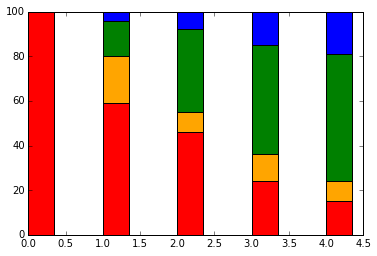

In [82]:
%matplotlib inline

import matplotlib.pyplot as plt

from collections import Counter

vects_of_dicts=[]
for i in range(5):
    vects_of_dicts.append(Counter(sample[i]))

times=[]
for j in range(4):
    times.append([vects_of_dicts[0].get(j,0),vects_of_dicts[1].get(j,0),
                 vects_of_dicts[2].get(j,0), vects_of_dicts[3].get(j,0),
                 vects_of_dicts[4].get(j,0)])

bottom=np.zeros(5)
colors=["red","orange","green",'blue']
ind=range(5)
width = 0.35
for i in range(4):
    p1 = plt.bar(ind, times[i], width, color=colors[i],bottom=bottom)
    bottom=bottom+np.array(times[i])

In [81]:
vects_of_dicts

[Counter({0: 100}),
 Counter({0: 59, 1: 21, 2: 16, 3: 4}),
 Counter({0: 46, 1: 9, 2: 37, 3: 8}),
 Counter({0: 24, 1: 12, 2: 49, 3: 15}),
 Counter({0: 15, 1: 9, 2: 57, 3: 19})]